In [16]:
import os
import pandas as pd

dataset_file_name = "IMDB Dataset.csv"

# Check if the dataset file exists in the current directory
if not os.path.exists(dataset_file_name):
    print(f"Error: {dataset_file_name} not found in the current directory.")

# Read the CSV file into a pandas DataFrame
data = pd.read_csv(dataset_file_name)

# Print a success message and display the first few rows of the dataset
print("Dataset loaded successfully!")
print(data.head())


Dataset loaded successfully!
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder to convert sentiment labels into numeric values
label_encoder = LabelEncoder()
data["sentiment_encoded"] = label_encoder.fit_transform(data["sentiment"])

# Define features (X) and target labels (y)
X = data["review"]
y = data["sentiment_encoded"]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the TF-IDF vectorizer to convert text data into numeric features
tfidf_vectorizer = TfidfVectorizer(max_features=20000, stop_words="english")

# Fit and transform the training data, and transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape


((40000, 20000), (10000, 20000))

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import mode
import numpy as np

# Initialize and fit KMeans model
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_tfidf)

# Predict cluster labels for test data
kmeans_labels = kmeans.predict(X_test_tfidf)

# Map predicted labels to sentiment labels based on training data
kmeans_mapped_labels = np.zeros_like(kmeans_labels)
for i in range(2):
    mask = (kmeans.labels_ == i)
    kmeans_mapped_labels[kmeans_labels == i] = mode(y_train[mask])[0]

kmeans_accuracy = accuracy_score(y_test, kmeans_mapped_labels)
kmeans_report = classification_report(y_test, kmeans_mapped_labels, target_names=label_encoder.classes_)

print("K-means accuracy:", kmeans_accuracy)
print("K-means report:", kmeans_report)


K-means accuracy: 0.5182
K-means report:               precision    recall  f1-score   support

    negative       0.52      0.40      0.45      5000
    positive       0.51      0.64      0.57      5000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.51     10000
weighted avg       0.52      0.52      0.51     10000



In [19]:
from sklearn.svm import LinearSVC

# Initialize and train SVM model
svm = LinearSVC(random_state=42)
svm.fit(X_train_tfidf, y_train)

# Make predictions on the test data
svm_predictions = svm.predict(X_test_tfidf)

svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_report = classification_report(y_test, svm_predictions, target_names=label_encoder.classes_)

print("SVM accuracy:", svm_accuracy)
print("SVM report:", svm_report)


SVM accuracy: 0.8942
SVM report:               precision    recall  f1-score   support

    negative       0.90      0.89      0.89      5000
    positive       0.89      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train MLP model
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation="relu", solver="adam", random_state=42, max_iter=100)
mlp.fit(X_train_tfidf, y_train)

# Make predictions on the test data
mlp_predictions = mlp.predict(X_test_tfidf)

mlp_accuracy = accuracy_score(y_test, mlp_predictions)
mlp_report = classification_report(y_test, mlp_predictions, target_names=label_encoder.classes_)

print("MLP accuracy:", mlp_accuracy)
print("MLP report:", mlp_report)


MLP accuracy: 0.8747
MLP report:               precision    recall  f1-score   support

    negative       0.88      0.87      0.87      5000
    positive       0.87      0.88      0.88      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



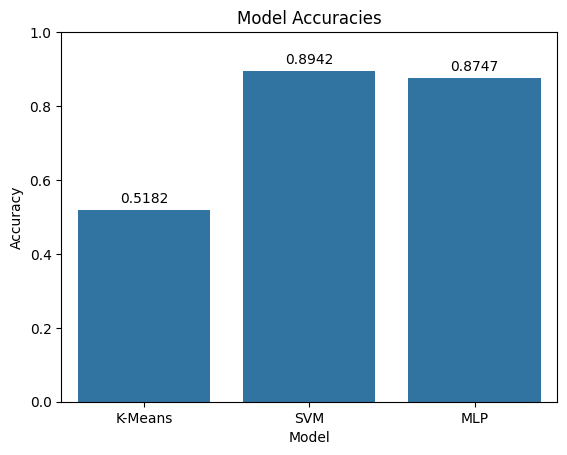

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Store model accuracies
model_accuracies = {
    "K-Means": kmeans_accuracy,
    "SVM": svm_accuracy,
    "MLP": mlp_accuracy,
}

# Create a bar plot for model accuracies
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()))
plt.title("Model Accuracies")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

# Annotate each bar with its accuracy value
for index, value in enumerate(model_accuracies.values()):
    plt.text(index, value + 0.02, value, ha="center", fontsize=10)

plt.show()


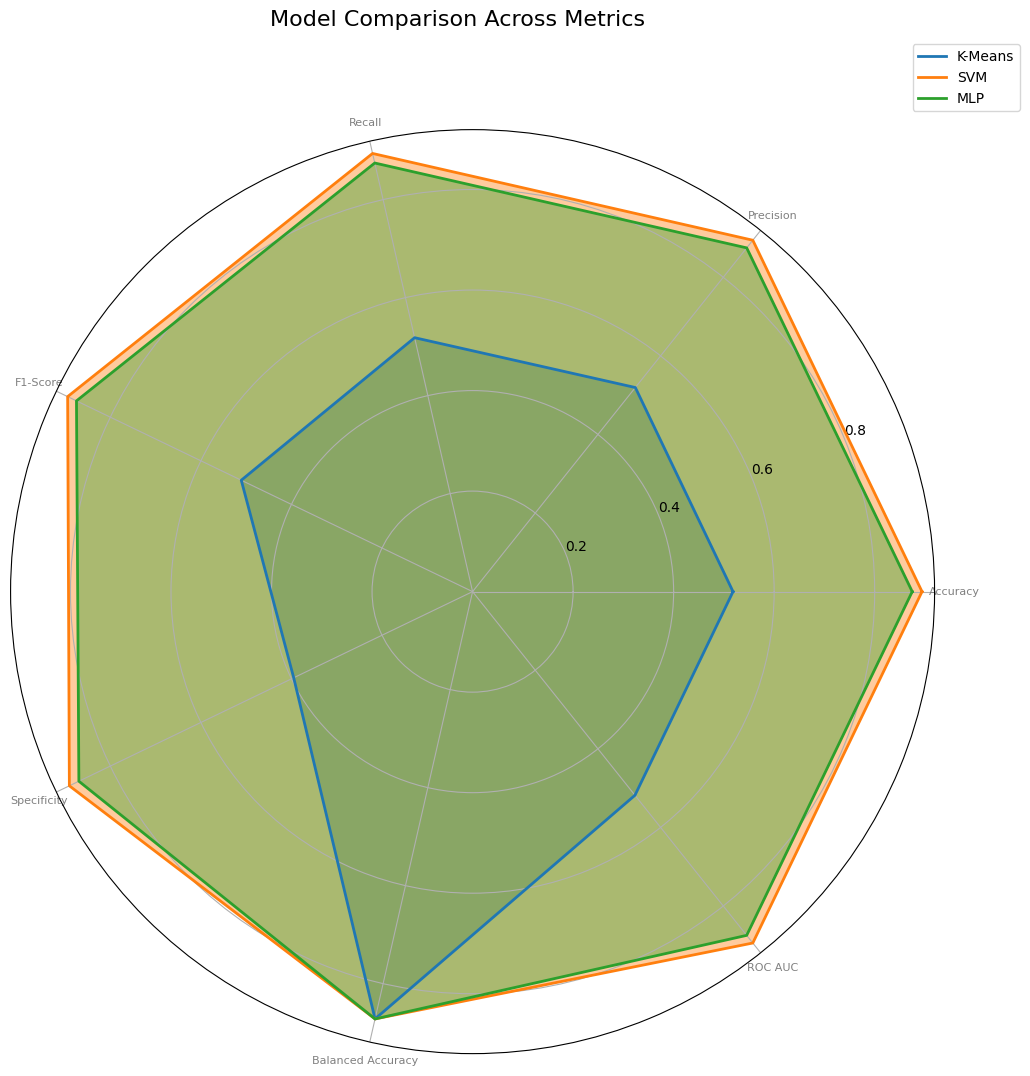

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, log_loss, roc_curve

# Calculate specificity (True Negative Rate)
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, _, _ = cm.ravel()
    return tn / (tn + fp)

# Create radar (web) chart for model metrics
def radar_chart(metrics_data, model_name, ax):
    categories = list(metrics_data.keys())
    values = list(metrics_data.values())

    values += values[:1]
    angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
    angles += angles[:1]

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, color='grey', size=8)
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name)
    ax.fill(angles, values, alpha=0.4)

# Define models and their predictions
models = {
    "K-Means": {"y_true": y_test, "y_pred": kmeans_mapped_labels},
    "SVM": {"y_true": y_test, "y_pred": svm_predictions},
    "MLP": {"y_true": y_test, "y_pred": mlp_predictions}
}

# Compute metrics for each model
model_metrics = {}
for model_name, data in models.items():
    y_true, y_pred = data['y_true'], data['y_pred']
    model_metrics[model_name] = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "F1-Score": f1_score(y_true, y_pred, average='weighted'),
        "Specificity": specificity(y_true, y_pred),
        "Balanced Accuracy": (rec + spec) / 2,
        "ROC AUC": roc_auc_score(y_true, y_pred)
    }

# Create radar (web) chart visualization
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
fig.suptitle('Model Comparison Across Metrics', size=16)

for model_name, metrics_data in model_metrics.items():
    radar_chart(metrics_data, model_name, ax)

ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()


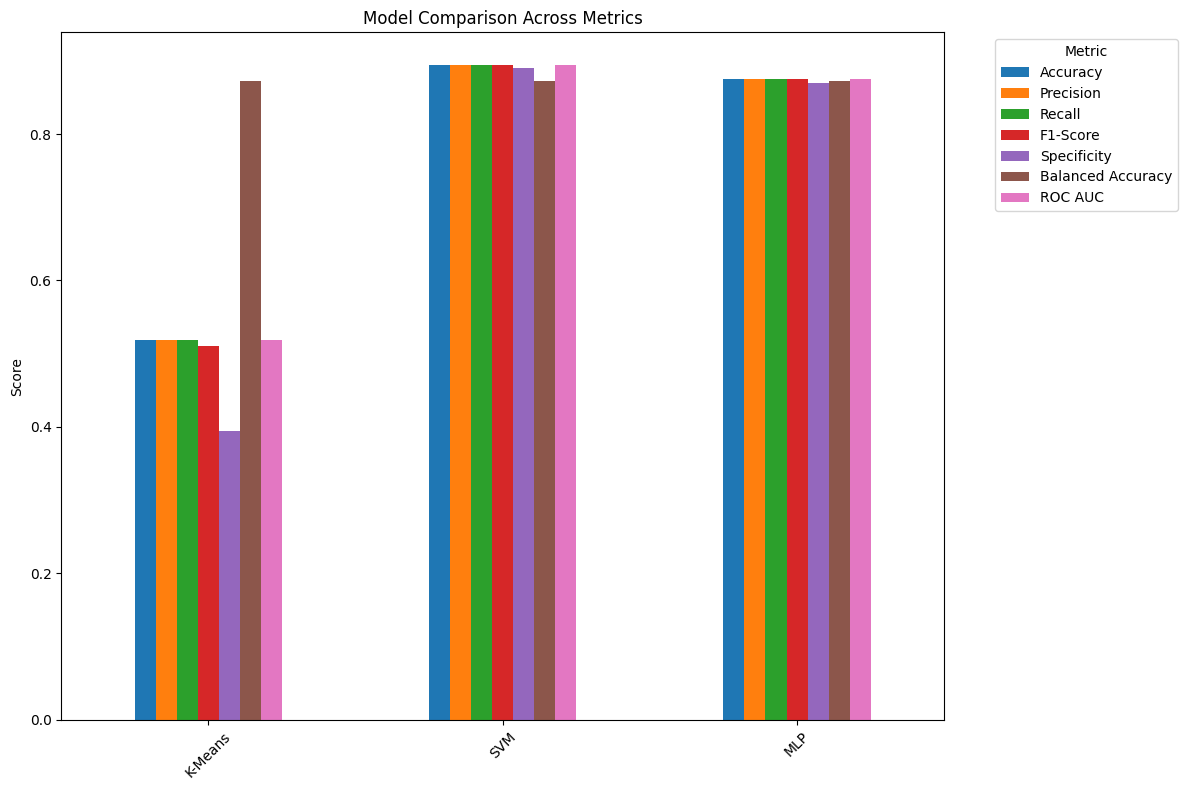

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert model metrics into a DataFrame for easier plotting
metrics_df = pd.DataFrame(model_metrics).T

# Plot the metrics as a bar chart
metrics_df.plot(kind='bar', figsize=(12, 8), rot=45)
plt.title('Model Comparison Across Metrics')
plt.ylabel('Score')

plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [24]:
log_loss_results = {}
misclassification_rate_results = {}

# Calculate log loss and misclassification rate for each model
for model_name, data in models.items():
    y_true, y_pred = data['y_true'], data['y_pred']
    
    if model_name != "K-Means":
        if model_name == "SVM":
            y_prob = svm.decision_function(X_test_tfidf)
        else:
            y_prob = mlp.predict_proba(X_test_tfidf)[:, 1]
        log_loss_results[model_name] = log_loss(y_true, y_prob)
    
    misclassification_rate_results[model_name] = 1 - accuracy_score(y_true, y_pred)

print("Log Loss Results:", log_loss_results)
print("Misclassification Rate Results:", misclassification_rate_results)


Log Loss Results: {'SVM': 2.1971539514844625, 'MLP': 1.4007071268769464}
Misclassification Rate Results: {'K-Means': 0.4818, 'SVM': 0.1058, 'MLP': 0.12529999999999997}


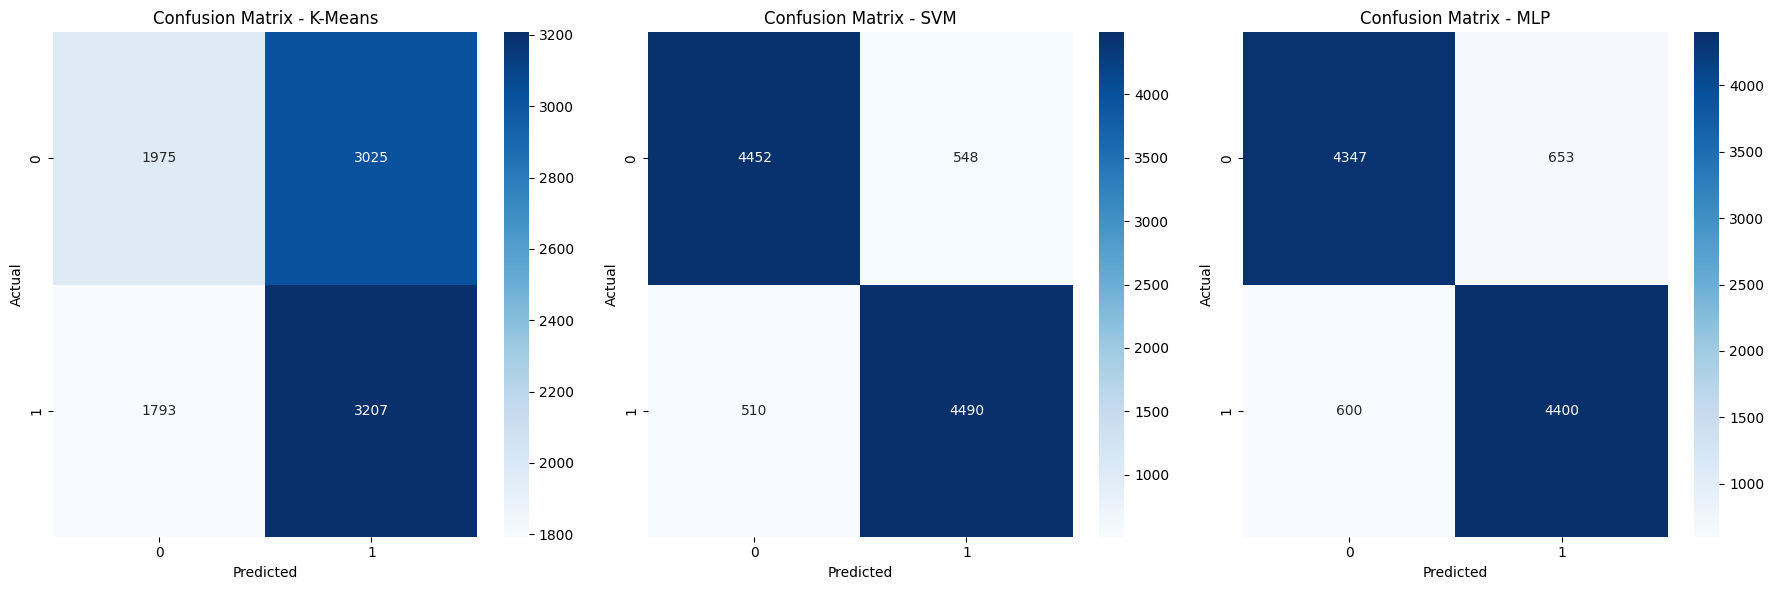

In [25]:
import seaborn as sns

# Create subplots for confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Generate confusion matrix for each model
for i, (model_name, data) in enumerate(models.items()):
    cm = confusion_matrix(data['y_true'], data['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {model_name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


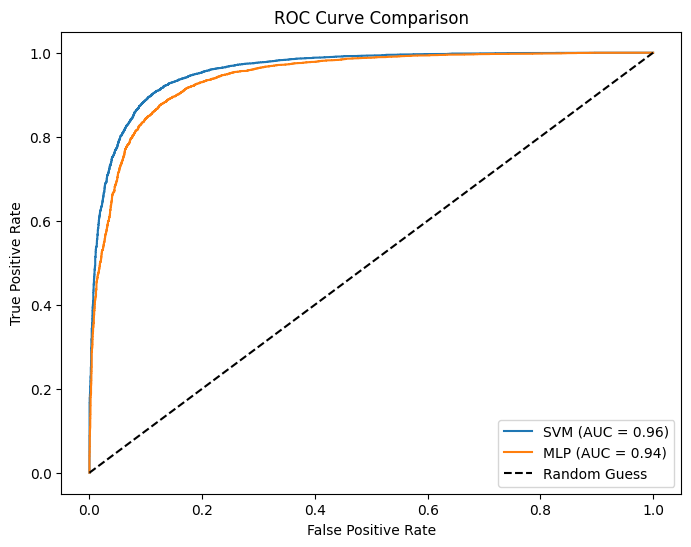

In [26]:
plt.figure(figsize=(8, 6))

# Generate ROC curve for each model
for model_name, data in models.items():
    y_true = data['y_true']
    if model_name != "K-Means":
        if model_name == "SVM":
            y_scores = svm.decision_function(X_test_tfidf)
        else:
            y_scores = mlp.predict_proba(X_test_tfidf)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        auc_score = roc_auc_score(y_true, y_scores)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()


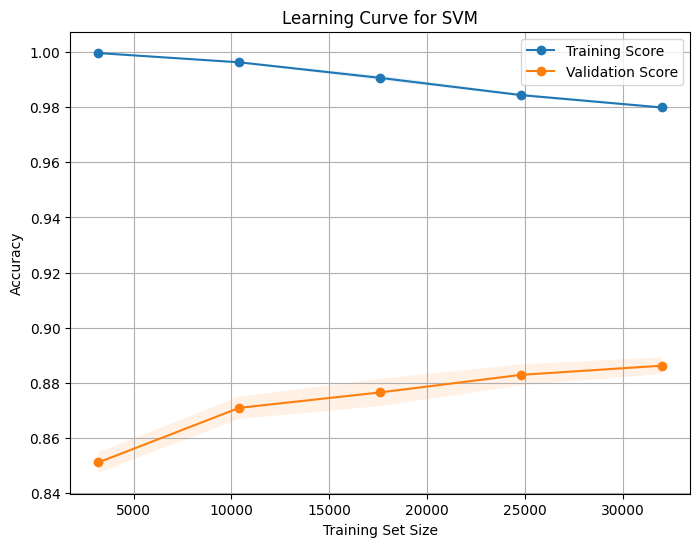

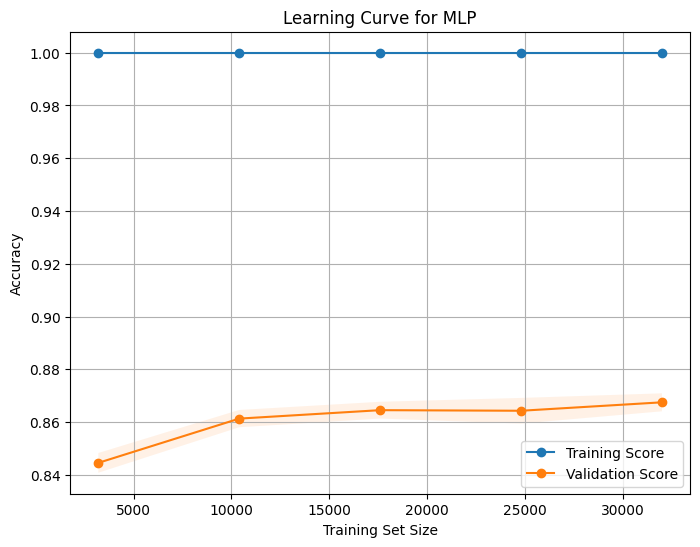

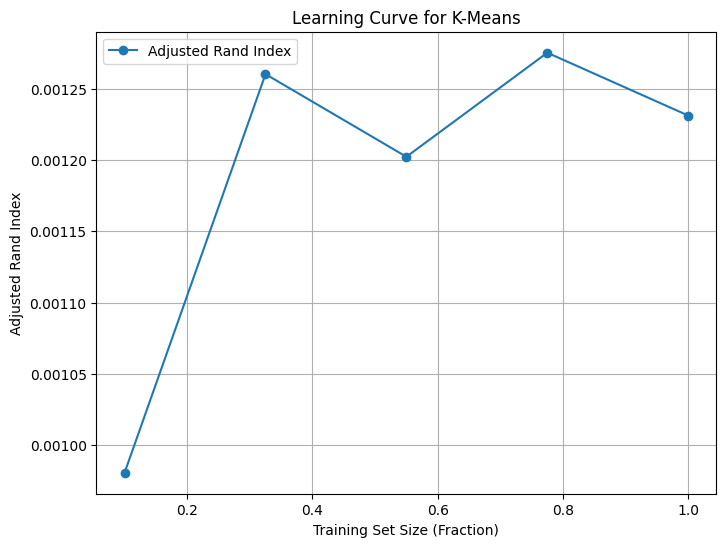

In [27]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import adjusted_rand_score
import numpy as np
import matplotlib.pyplot as plt

# Function to plot learning curve for a given model
def plot_learning_curve(model, model_label, scoring, X_train, y_train):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label="Training Score", marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.plot(train_sizes, test_mean, label="Validation Score", marker='o')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    plt.xlabel("Training Set Size")
    plt.ylabel(scoring.capitalize())
    plt.title(f"Learning Curve for {model_label}")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Plot learning curves for SVM and MLP
for model, model_label, scoring in [(svm, "SVM", "accuracy"), (mlp, "MLP", "accuracy")]:
    plot_learning_curve(model, model_label, scoring, X_train_tfidf, y_train)

# Calculate learning curve for K-Means using Adjusted Rand Index
kmeans_scores = []
train_sizes = np.linspace(0.1, 1.0, 5)
num_samples = X_train_tfidf.shape[0]

# Train K-Means on different sample sizes and compute ARI
for train_size in train_sizes:
    sample_size = int(num_samples * train_size)
    X_sample = X_train_tfidf[:sample_size] 
    y_sample = y_train[:sample_size]
    
    kmeans.fit(X_sample)
    kmeans_labels_sample = kmeans.predict(X_test_tfidf)

    ari_score = adjusted_rand_score(y_test, kmeans_labels_sample)
    kmeans_scores.append(ari_score)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, kmeans_scores, label="Adjusted Rand Index", marker='o')
plt.xlabel("Training Set Size (Fraction)")
plt.ylabel("Adjusted Rand Index")
plt.title("Learning Curve for K-Means")
plt.legend(loc="best")
plt.grid()
plt.show()


In [28]:
models_coefficients = {
    "SVM": svm.coef_[0],
    "MLP": mlp.coefs_[0][:, 0], 
}

# Get TF-IDF feature names
feature_names = tfidf_vectorizer.get_feature_names_out() 

# Print top 10 features for SVM and MLP
for model_name, coefficients in models_coefficients.items():
    sorted_indices = np.argsort(np.abs(coefficients))[::-1] 
    for idx in sorted_indices[:10]: 
        print(f"{feature_names[idx]}: {coefficients[idx]}")

# Print top 10 words for each K-Means cluster
for cluster_idx, cluster_center in enumerate(kmeans.cluster_centers_):
    sorted_indices = np.argsort(cluster_center)[::-1]
    top_words = [feature_names[idx] for idx in sorted_indices[:10]]
    print(f"Cluster {cluster_idx}: {', '.join(top_words)}")


worst: -5.464992650333299
waste: -5.3232480295651685
awful: -4.372178451966168
excellent: 3.6694307371740305
disappointment: -3.5336610556152137
fails: -3.481647697422615
disappointing: -3.477607488146168
great: 3.2605928285491794
boring: -3.247897535952324
poorly: -3.24549987137041
worst: -0.21112653092423525
waste: -0.19180806564604153
horrible: -0.17499010205488968
dismiss: 0.16886556870594144
awful: -0.14262666603493632
poorly: -0.13894883492972185
fails: -0.1299652811879023
scriptwriters: -0.12154122439421665
lousy: -0.11950625748918774
disappointment: -0.11921752081710413
Cluster 0: br, movie, film, like, just, good, really, story, bad, time
Cluster 1: movie, film, br, like, just, good, really, time, story, great


In [29]:
models_predictions = {
    "SVM": svm_predictions,
    "MLP": mlp_predictions,
    "K-Means": kmeans_mapped_labels,
}

# Print examples of false positives and false negatives for each model
for model_name, predictions in models_predictions.items():
    print(f"--- {model_name} ---")
    
    false_positives = (y_test == 0) & (predictions == 1)
    false_negatives = (y_test == 1) & (predictions == 0)

    print("Examples of False Positives:")
    print(X_test[false_positives][:5])
    
    print("\nExamples of False Negatives:")
    print(X_test[false_negatives][:5])
    
    print("\n")


--- SVM ---
Examples of False Positives:
18870    Yes, MTV there really is a way to market Daria...
40882    This movie is really wack. There is really not...
40714    Little Quentin seems to have mastered the art ...
31882    The film listed here as having been made in 19...
11840    I had known Brad Linaweaver at Florida State U...
Name: review, dtype: object

Examples of False Negatives:
46536    I just can't believe some of the comments on t...
39806    1. I've seen Branaghs Hamlet: Branagh is too o...
45621    Ladies and gentlemen, we've really got ourselv...
1396     Citizen Kane....The Godfather Part II....D'Urv...
5000     Not a movie for everyone, but this movie is in...
Name: review, dtype: object


--- MLP ---
Examples of False Positives:
18870    Yes, MTV there really is a way to market Daria...
40882    This movie is really wack. There is really not...
40714    Little Quentin seems to have mastered the art ...
31882    The film listed here as having been made in 19...
4142

In [30]:
import time

# K-Means training time
start_time = time.time()
kmeans.fit(X_train_tfidf)
kmeans_training_time = time.time() - start_time
print(f"Training Time for K-Means: {kmeans_training_time:.2f} seconds")

# SVM training time
start_time = time.time()
svm.fit(X_train_tfidf, y_train)
svm_training_time = time.time() - start_time
print(f"Training Time for SVM: {svm_training_time:.2f} seconds")

# MLP training time
start_time = time.time()
mlp.fit(X_train_tfidf, y_train)
mlp_training_time = time.time() - start_time
print(f"Training Time for MLP: {mlp_training_time:.2f} seconds")


Training Time for K-Means: 0.13 seconds
Training Time for SVM: 0.87 seconds
Training Time for MLP: 218.38 seconds
